In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [26]:
def classify_image(image_path, visualize=True, diff_threshold=150):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return "Image Not Found", None
    color_img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    blur = cv2.GaussianBlur(img, (5, 5), 0)
    _, binary = cv2.threshold(blur, 127, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        return "No Object Found", color_img
    c = max(contours, key=cv2.contourArea)
    mask = np.zeros_like(binary)
    cv2.drawContours(mask, [c], -1, 255, -1)
    (x, y), r = cv2.minEnclosingCircle(c)
    ideal_mask = np.zeros_like(binary)
    cv2.circle(ideal_mask, (int(x), int(y)), int(r), 255, -1)
    diff = cv2.absdiff(mask, ideal_mask)
    diff_area = np.sum(diff > 0)
    print("diff_area:", diff_area)  # Debug print

    if visualize:
        plt.figure(figsize=(12,4))
        plt.subplot(1,3,1)
        plt.title("Mask")
        plt.imshow(mask, cmap='gray')
        plt.axis('off')
        plt.subplot(1,3,2)
        plt.title("Ideal Mask")
        plt.imshow(ideal_mask, cmap='gray')
        plt.axis('off')
        plt.subplot(1,3,3)
        plt.title("Diff")
        plt.imshow(diff, cmap='gray')
        plt.axis('off')
        plt.show()

    # 1. Good detection
    if diff_area < diff_threshold:
        return "Good", color_img

    # 2. Defect type detection
    # Flash: extra pixels outside ideal mask
    flash_area = np.sum((diff > 0) & (ideal_mask == 0))
    # Cut: missing pixels inside ideal mask
    cut_area = np.sum((diff > 0) & (ideal_mask == 255))
    print("flash_area:", flash_area, "cut_area:", cut_area)

    if flash_area > cut_area:
        label = "Flash"
        defect_color = (0, 255, 255)
    elif cut_area > flash_area:
        label = "Cut"
        defect_color = (0, 0, 255)
    else:
        label = "Defect"
        defect_color = (255, 0, 0)

    defect_contours, _ = cv2.findContours(diff, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for d in defect_contours:
        if cv2.contourArea(d) > 30:
            x, y, w, h = cv2.boundingRect(d)
            cv2.rectangle(color_img, (x, y), (x+w, y+h), defect_color, 2)
    return label, color_img

diff_area: 23175


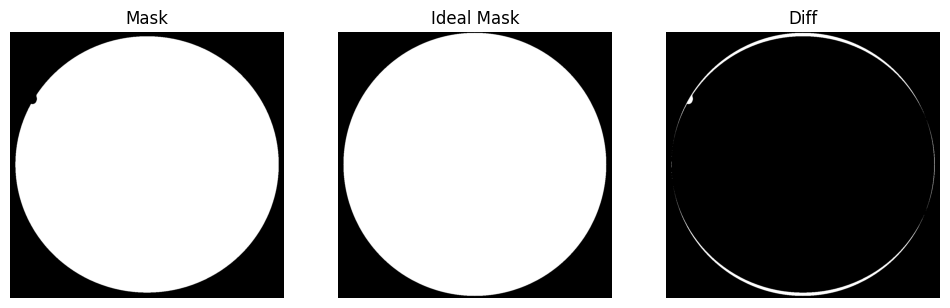

flash_area: 555 cut_area: 22620


In [31]:

# Example usage
test_img = "C:/Users/seshajalam/Desktop/DA/projects/defect2.png"   # change to your image path
result, vis_img = classify_image(test_img, visualize=True, diff_threshold=150)  # Adjust threshold if needed


Classification: Cut


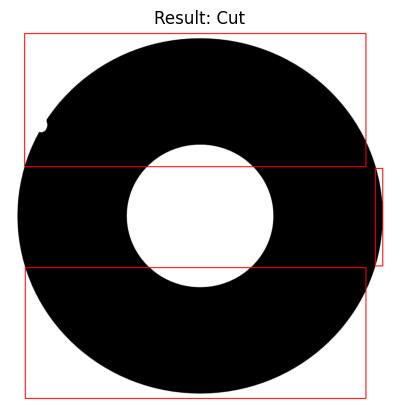

In [32]:

print("Classification:", result)
if vis_img is not None:
    plt.imshow(cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Result: {result}")
    plt.axis('off')
    plt.show()
else:
    print("Image not found or could not be loaded.")